In [178]:
import pandas as pd
%matplotlib inline
import numpy as np
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

In [197]:
data = pd.read_csv('./features.csv', index_col='match_id')
features = data.drop( labels=['duration','radiant_win','tower_status_radiant', 'tower_status_dire',
       'barracks_status_radiant', 'barracks_status_dire'],axis=1)
empty_count = features.shape[0] - features.count()
features_with_missing_values = list(empty_count[empty_count != 0].keys())
features = features.fillna(0)
features = pd.DataFrame(PCA(30).fit_transform(features))

In [198]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from datetime import datetime

X_train, X_test, y_train, y_test = train_test_split(features,data.radiant_win)


n_splits = 5
cv = KFold(n_splits=n_splits,shuffle=True)

scores_train = list()
scores_test = list()
train_times = list()

for i in range(0,10,2):
    tree_cnt = (i+1)*10
    
    score_sum = 0
    clf = GradientBoostingClassifier(n_estimators=tree_cnt, max_depth=2)

    start = datetime.now()
    for train_index, test_index in cv.split(X_train,y_train):
        X_train_curr = X_train.values[train_index]
        y_train_curr = y_train.values[train_index]
        clf.fit(X_train_curr,y_train_curr)
        score = roc_auc_score(y_train.values[test_index],clf.predict(X_train.values[test_index]))
        score_sum+=score
    delta = (datetime.now() - start).seconds
    train_times.append(delta)
    
    score_train = score_sum/n_splits
    score_test = roc_auc_score(y_test.values,clf.predict(X_test.values))
    scores_train.append(score_train)
    scores_test.append(score_test)
    
    print(f'Tree count: {tree_cnt}; Average train score: {score_train}; Test score: {score_test}; Time {delta} seconds')
    

Tree count: 10; Average train score: 0.6475715382203202; Test score: 0.6487643923439241; Time 9 seconds
Tree count: 30; Average train score: 0.6492262877108582; Test score: 0.6481929286522328; Time 27 seconds
Tree count: 50; Average train score: 0.6499988342089871; Test score: 0.6498176328568295; Time 44 seconds
Tree count: 70; Average train score: 0.6507356511991066; Test score: 0.6496884134260138; Time 60 seconds
Tree count: 90; Average train score: 0.6512944495717938; Test score: 0.6490508475529537; Time 79 seconds


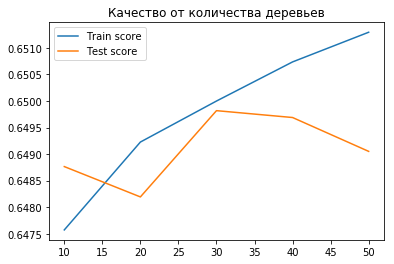

In [199]:
trees_list = np.arange(1,len(scores_train)+1)*10

plt.title('Качество от количества деревьев')
plt.plot(trees_list,scores_train)
plt.plot(trees_list,scores_test)
plt.legend(['Train score','Test score'])



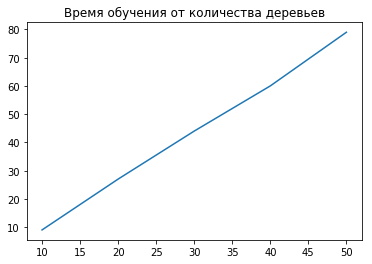

In [200]:
plt.title('Время обучения от количества деревьев')
plt.plot(trees_list,train_times)


### Подход 1: градиентный бустинг "в лоб". Отчёт

1. В 12 признаках есть пропуски, к примеру: first_blood_time, radiant_bottle_time, если событие "первая кровь" не произошло или предмет bottle не был приобретён. Ниже список признаков с пропусками:

 'first_blood_time',
 'first_blood_team',
 'first_blood_player1',
 'first_blood_player2',
 'radiant_bottle_time',
 'radiant_courier_time',
 'radiant_flying_courier_time',
 'radiant_first_ward_time',
 'dire_bottle_time',
 'dire_courier_time',
 'dire_flying_courier_time',
 'dire_first_ward_time'
 
2. Целевую переменную содержит столбец **radiant_win**
3. ROC-AUC при 30 деревьях: 0.6364, 

    время обучения: 89 секунд
    
4. При увеличении числа деревьев растет качество на обучающей и тестовой выборках, при этом рост замедляется, тогда как время обучения линейно растёт. 
        
      Для ускорения обучения можно :
      * Задать меньшую глубину деревьям
      * Уменьшить количество признаков с помощью метода главных компонент
      

In [123]:
features_with_missing_values

['first_blood_time',
 'first_blood_team',
 'first_blood_player1',
 'first_blood_player2',
 'radiant_bottle_time',
 'radiant_courier_time',
 'radiant_flying_courier_time',
 'radiant_first_ward_time',
 'dire_bottle_time',
 'dire_courier_time',
 'dire_flying_courier_time',
 'dire_first_ward_time']